# Age and Gender Prediction through Face images #

## Importing all useful libraries ##

In [58]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm # for iterating through directory with showing off the bar progess of loading values to the variables/objects.
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
from keras.preprocessing.image import load_img, random_zoom, random_brightness, random_shear, random_shift, random_channel_shift
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input 

# Load dataset #

In [59]:
#Load image directory
img_dir = '/Users/shitleshbakshi/Library/CloudStorage/OneDrive-UniversityofSouthWales/Deep_Learning_Assignment_I/UTKFace'

In [60]:
# Fetch image's age, gender and race labels
img_label = []
age_label = []
gender_label = []

for file in tqdm(os.listdir(img_dir)):
    img_path = os.path.join(img_dir,file)
    tmp = file.split('_')
    img_label.append(img_path)
    age_label.append(int(tmp[0]))
    gender_label.append(int(tmp[1]))

# Create dataframe
dataset = pd.DataFrame()
dataset['image'], dataset['age'], dataset['gender'] = img_label, age_label,gender_label
# dataset = dataset[dataset['gender']!= 3]
dataset.head()
# dataset.info()

  0%|          | 0/23709 [00:00<?, ?it/s]

image  age  gender
0  /Users/shitleshbakshi/Library/CloudStorage/One...    9       1
1  /Users/shitleshbakshi/Library/CloudStorage/One...   36       0
2  /Users/shitleshbakshi/Library/CloudStorage/One...   86       1
3  /Users/shitleshbakshi/Library/CloudStorage/One...   26       1
4  /Users/shitleshbakshi/Library/CloudStorage/One...    1       1

In [61]:
# Map Gender labels
dict_gender = {0:'Man', 1:'Woman'}

## Data Analysis & Preprocessing ##

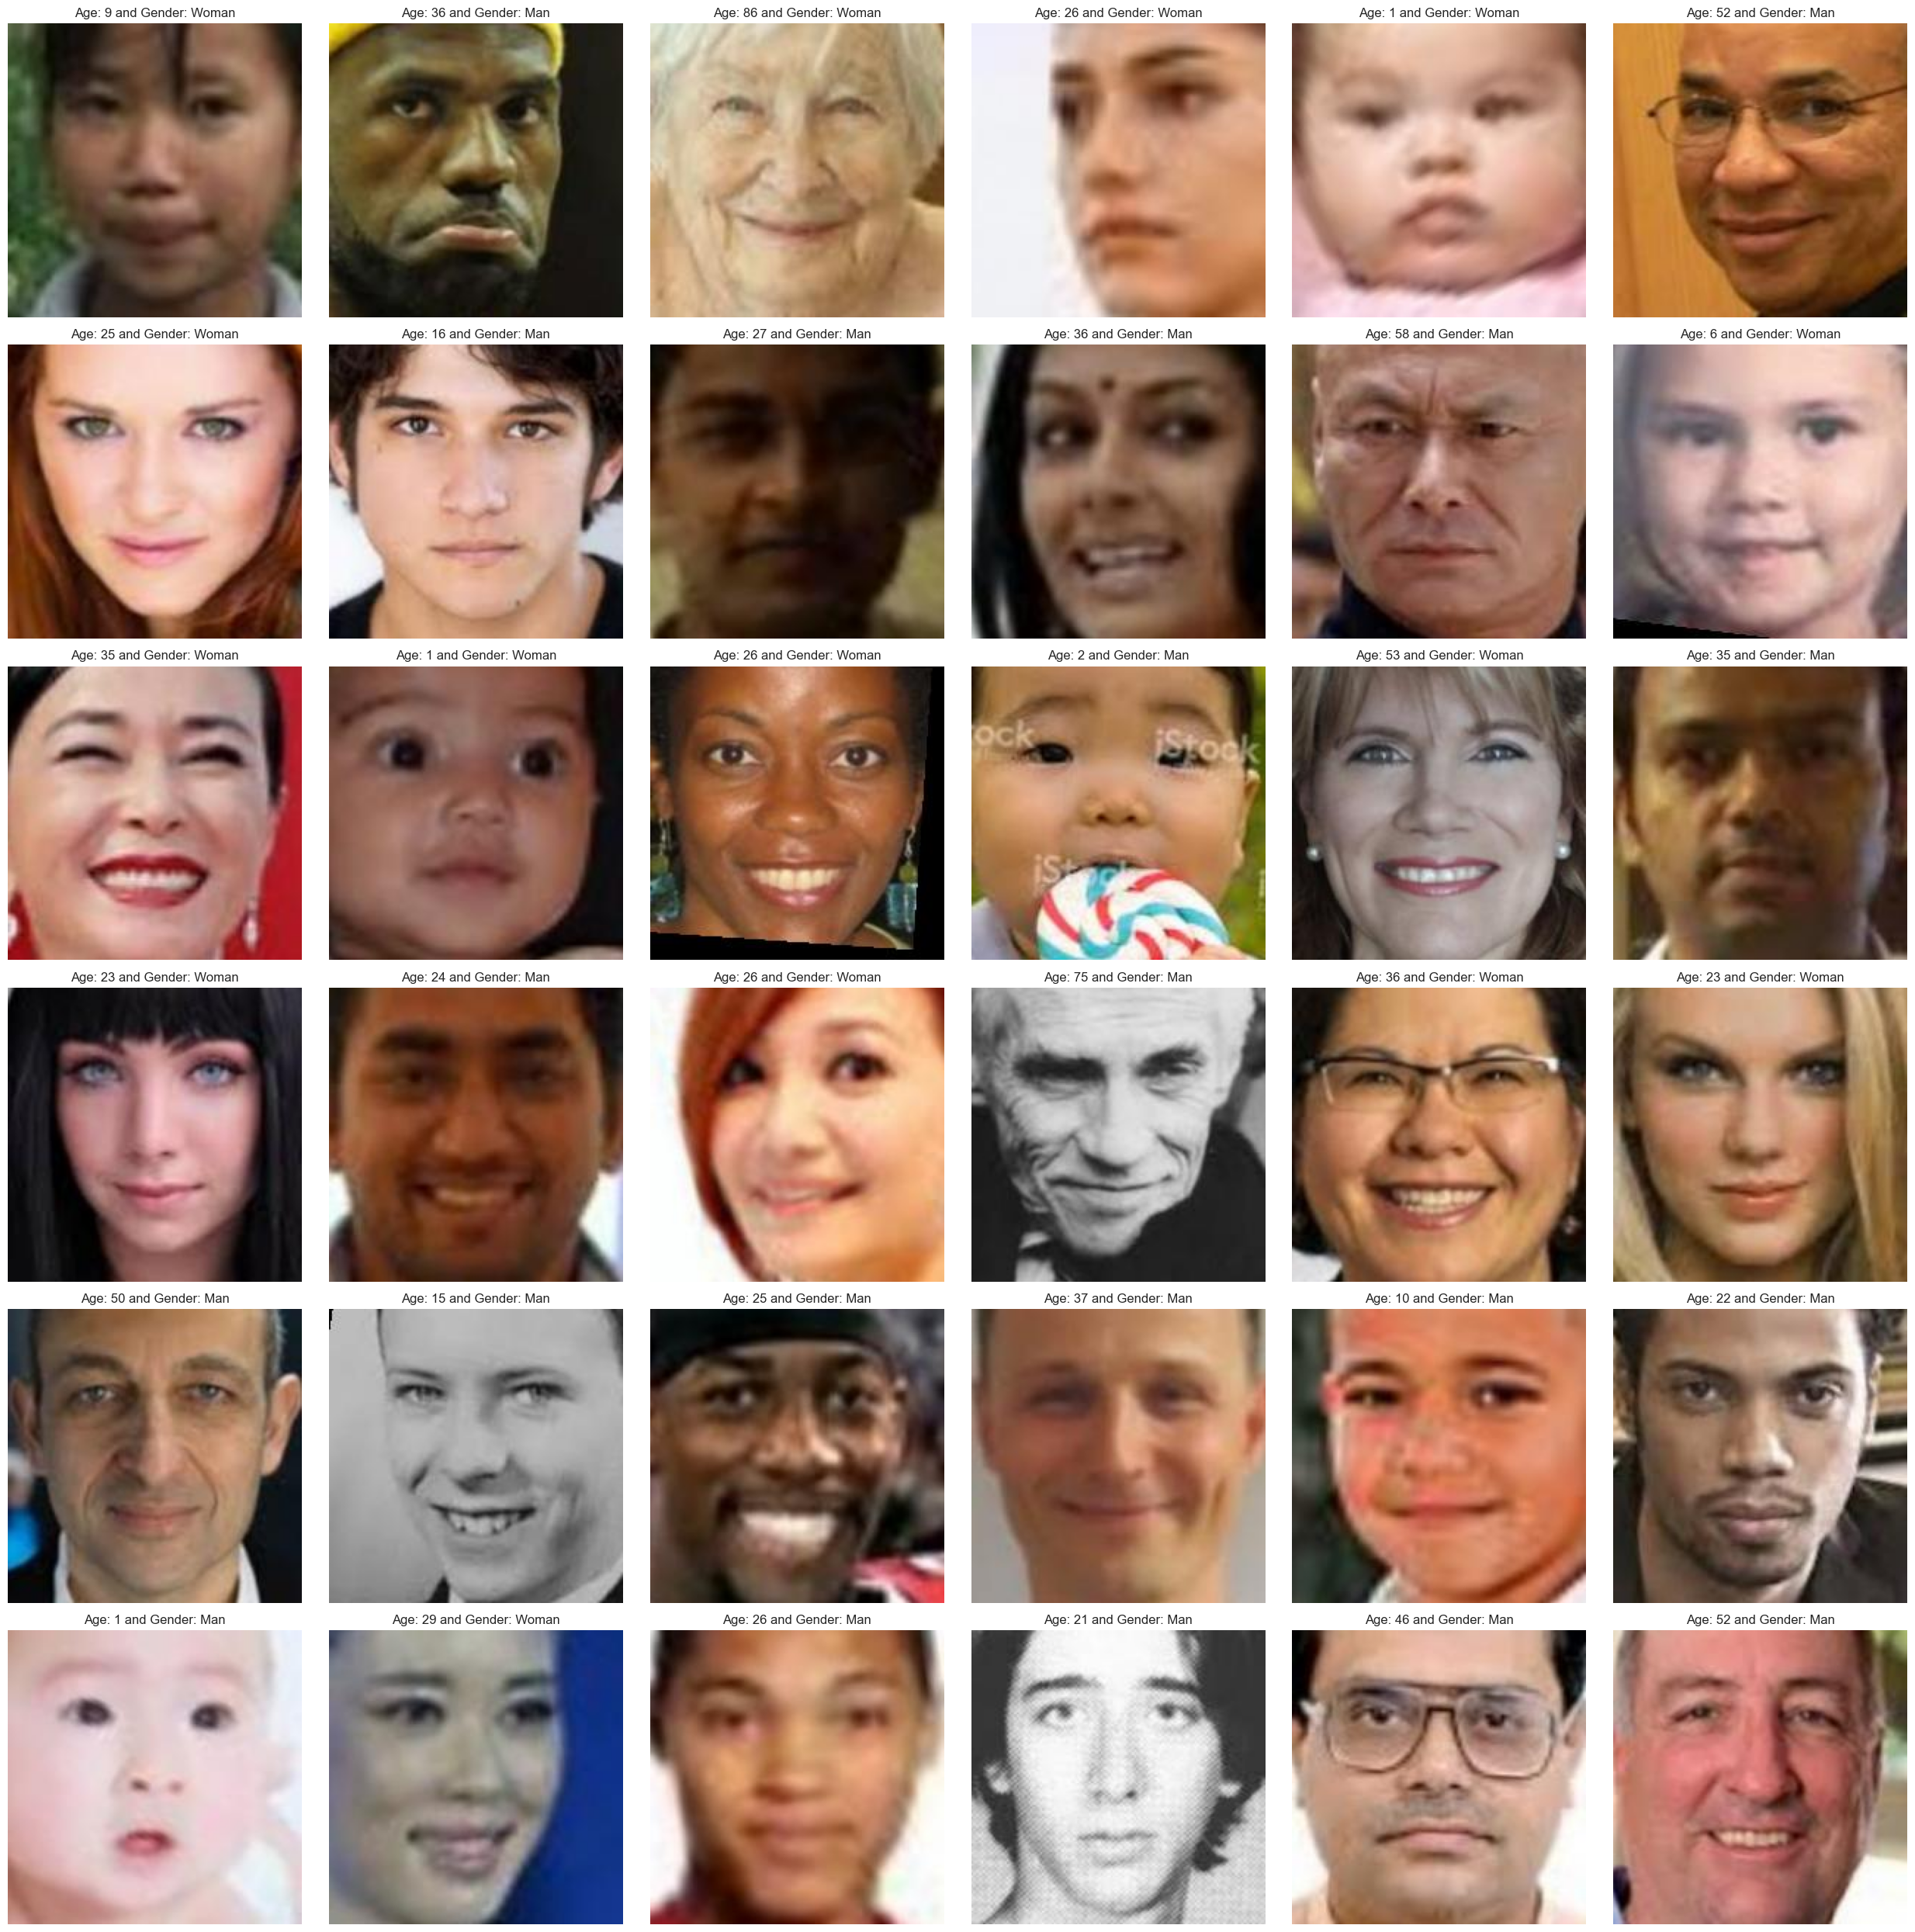

In [62]:
files = dataset.loc[0:35]
# Display unprocessed images
plt.figure(figsize=(25,25))
for i, file, age, gender in files.itertuples():
    plt.subplot(6,6,i+1)
    img = np.array(load_img(file))
    plt.imshow(img)
    plt.title(f'Age: {age} and Gender: {dict_gender[gender]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Feature Extraction ##

In [63]:
def extract_features(imgs):
    features = []
    for img in tqdm(imgs):
        image = load_img(img, color_mode='rgb')
        
        # random_zoom, random_brightness, random_shear, random_shift, random_channel_shift
        
        image = image.rotate(90)
        image = image.transpose(1)
        image = image.resize((224, 224))
        image = np.array(image)
        zoom_img = random_zoom(image,fill_mode='nearest', zoom_range=(1-0.1,1+0.1))
        brightness_img = random_brightness(zoom_img,brightness_range = (0.5,1.9), scale=True)
        shear_img = random_shear(brightness_img,intensity=0.5, fill_mode='nearest')
        normalised_img = shear_img/255.0
        
        features.append(normalised_img)
        
    features = np.array(features)
    features = features.reshape(len(features), 224 , 224, 3)
    features = features.mean(axis=-1)
    return features

In [64]:
img_features = extract_features(img_label)

  0%|          | 0/23709 [00:00<?, ?it/s]

In [65]:
feature_age = np.array(dataset['age'])
features_gender = np.array(dataset['gender'])

## CNN Model ##

In [66]:
import tensorflow
from tensorflow.keras import layers, models

#Split data into training and testing data

# X_train, X_test, y_train, y_test = train_test_split(img_features,test_size=0.3, random_state= 42)

def cnn_model():
    
        input_layer = layers.Input(shape = (224,224,1))
        # Convolutional layers
        x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(128, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(256, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(512, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        # Flatten the output 
        x = layers.Flatten()(x)
        # add fully connected layers for age prediction
        x_age = layers.Dense(512, activation='linear')(x)
        x_age = layers.Dropout(0.5)(x_age)
        age_output = layers.Dense(1, activation='linear', name = 'age_output')(x_age)  
        
        # add fully connected layers for gender prediction
        x_gender = layers.Dense(512, activation='sigmoid')(x)
        x_gender = layers.Dropout(0.5)(x_gender)
        gender_output = layers.Dense(1, activation='sigmoid', name = 'gender_output')(x_gender)  # Binary classification, so use sigmoid activation
        
     
     #Create model with two outputs
        model = models.Model(inputs=input_layer, outputs=[age_output, gender_output])
        
    # Compile the model
        model.compile(optimizer='adam',
                  loss={'age_output':'mean_squared_error','gender_output':'binary_crossentropy'},
                  metrics={'age_output':'mean_absolute_error','gender_output':'accuracy'})

        return model


# Create an instance of the model
model = cnn_model()
# Train the model
history = model.fit(x=img_features, y={'age_output':feature_age,'gender_output': features_gender}, batch_size = 32, epochs=100, validation_steps=50, validation_split = 0.25) 

Epoch 1/100


2024-01-26 14:42:47.879516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


556/556 [==============================] - ETA: 0s - loss: 426.5686 - age_output_loss: 425.8568 - gender_output_loss: 0.7121 - age_output_mean_absolute_error: 15.8021 - gender_output_accuracy: 0.5190

2024-01-26 14:43:35.487358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


556/556 [==============================] - 50s 86ms/step - loss: 426.5686 - age_output_loss: 425.8568 - gender_output_loss: 0.7121 - age_output_mean_absolute_error: 15.8021 - gender_output_accuracy: 0.5190 - val_loss: 381.5371 - val_age_output_loss: 380.8414 - val_gender_output_loss: 0.6956 - val_age_output_mean_absolute_error: 15.9288 - val_gender_output_accuracy: 0.5325
Epoch 2/100
556/556 [==============================] - 52s 92ms/step - loss: 318.8832 - age_output_loss: 318.2627 - gender_output_loss: 0.6205 - age_output_mean_absolute_error: 13.6701 - gender_output_accuracy: 0.6466 - val_loss: 205.0725 - val_age_output_loss: 204.5442 - val_gender_output_loss: 0.5283 - val_age_output_mean_absolute_error: 10.8201 - val_gender_output_accuracy: 0.7431
Epoch 3/100
556/556 [==============================] - 51s 92ms/step - loss: 200.4749 - age_output_loss: 199.9653 - gender_output_loss: 0.5097 - age_output_mean_absolute_error: 10.8081 - gender_output_accuracy: 0.7477 - val_loss: 155.7232

In [67]:
model.save('age_model.h5')

/Users/shitleshbakshi/tensorflow-home/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Prediction and Result ## 

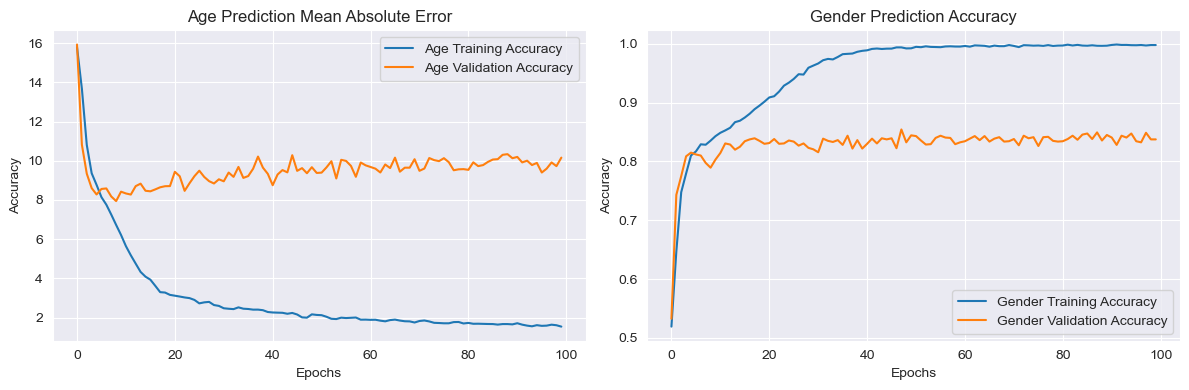

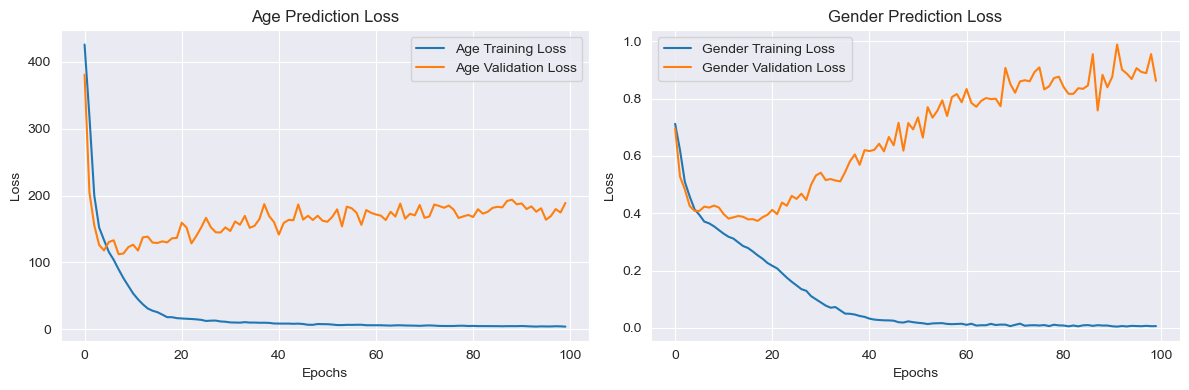

In [68]:

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['age_output_mean_absolute_error'], label='Age Training Accuracy') 
plt.plot(history.history['val_age_output_mean_absolute_error'], label='Age Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Age Prediction Mean Absolute Error') 

plt.subplot(1, 2, 2)
plt.plot(history.history['gender_output_accuracy'], label='Gender Training Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Gender Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Gender Prediction Accuracy')

plt.tight_layout()
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['age_output_loss'], label='Age Training Loss')
plt.plot(history.history['val_age_output_loss'], label='Age Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Age Prediction Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['gender_output_loss'], label='Gender Training Loss')
plt.plot(history.history['val_gender_output_loss'], label='Gender Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gender Prediction Loss')

plt.tight_layout()
plt.show()

Original Gender: 0 Original Age: 54


2024-01-26 16:19:57.734569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 300ms/step
Predicted Gender: [3.5062906e-06] Predicted Age: [39.]
Original Gender: 1 Original Age: 70
1/1 [==============================] - 0s 31ms/step
Predicted Gender: [0.99999917] Predicted Age: [56.]
Original Gender: 1 Original Age: 22
1/1 [==============================] - 0s 17ms/step
Predicted Gender: [0.9983633] Predicted Age: [19.]
Original Gender: 0 Original Age: 54
1/1 [==============================] - 0s 16ms/step
Predicted Gender: [5.6142187e-07] Predicted Age: [42.]
Original Gender: 1 Original Age: 28
1/1 [==============================] - 0s 15ms/step
Predicted Gender: [1.] Predicted Age: [19.]


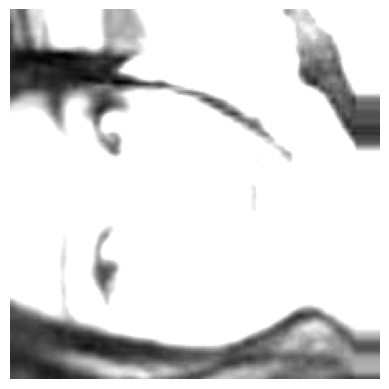

In [69]:
# Sample output from training dataset
for img_idx in range(5):
    image_index = np.random.randint(len(img_features))
    print("Original Gender:", features_gender[image_index], "Original Age:", feature_age[image_index])
    # predict from model
    pred = model.predict(img_features[image_index].reshape(1,224,224,1))
    pred_age = np.round(pred[0][0])
    pred_gender = (pred[1][0])
    print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
    plt.axis('off')
    plt.imshow(img_features[image_index].reshape(224, 224), cmap='gray')

In [70]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 222, 222, 32)         320       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 32)         0         ['conv2d_20[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 109, 109, 64)         18496     ['max_pooling2d_20[0][0]